In [1]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi, SNLE
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
import numpy as np
import moments

from matplotlib import pyplot as plt
import dill
import os
import seaborn as sns
from joblib import Parallel, delayed
from sbi.inference import infer

/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [10]:
def momment_sim(prior):
    
    moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(10, gamma=prior, theta=100.0))  # returns a masked array
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    actual_fs = moment_data.compressed()  
    x = torch.poisson(torch.tensor(actual_fs))
    return x

def true_data(prior):
    
    if prior.shape[0] > 1:
        moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(10, gamma=prior[0].detach().cpu().numpy(), theta=100.0))
        actual_fs = moment_data.compressed()  
        x = torch.poisson(torch.tensor(actual_fs).repeat(prior.shape[0],1))
    else:
        moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(10, gamma=prior.detach().cpu().numpy(), theta=100.0))
        actual_fs = moment_data.compressed()  
        x = torch.poisson(torch.tensor(actual_fs))
    return x, actual_fs

In [3]:
import os
os.getcwd()

'/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/moments'

In [6]:
#CHeck moments
moment_data = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(10, gamma=2, theta=100.0))  # returns a masked array


In [11]:
prior = utils.BoxUniform(low=1 * torch.ones(1), high=100 * torch.ones(1), device='cuda')
pop_dim = 10
posteriors = [None]*(pop_dim-1)
weights = [None]*(pop_dim-1)

# Train SNLE
simulator, prior = prepare_for_sbi(momment_sim, prior)
inferer = SNLE(prior, show_progress_bars=False, device='cuda', density_estimator="maf")
num_sim = 100

In [12]:
# Obtain posterior samples for different number of iid "observed" xos.
num_iid_trials = 100
true_theta = []
true_x = []
# Generate IID samples from the same prior value
for i in range(num_iid_trials):
    theta_o = prior.sample((1,))
    true_theta.append(theta_o)
    x_o, _ = true_data(theta_o)
    true_x.append(x_o)
    
true_x = torch.stack(true_x).cuda()   

In [14]:
# Obtain posterior samples for different number of iid "observed" xos.
num_iid_trials = 100
# Generate IID samples from the same prior value
theta_o = prior.sample((1,))
print("theta for true: {}".format(theta_o))
x_o, actual_fs = true_data(theta_o.repeat(num_iid_trials,1))
    
true_x2 = x_o.cuda()  

theta for true: tensor([[63.1079]], device='cuda:0')


In [15]:
#posterior parameters
vi_parameters = dict(q="maf")

for i in range(1,pop_dim):
    
    theta, x = simulate_for_sbi(simulator, prior, num_sim)
    liklihood_estimator = inferer.append_simulations(theta, x).train()
    a_post = inferer.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
    posteriors[i-1] = a_post.set_default_x(true_x2).train(max_num_iters=40, quality_control=False )
    
    # Calculate p(i | X) ] = 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1))) where num_sim is the number of simulations
    #step 1 torch.sum(x, axis=1) # calculate sum(X_i_to_(pop_dim-1) for each simulation
    #step 2 x[:,i-1] / (torch.sum(x, axis=1)) # calculate X_i / sum(X_i_to_(pop_dim-1)) for each simulation
    #step 3 calculate 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1)))
    weights[i-1] = torch.mean(x[:,i-1] / (torch.sum(x, axis=1)))

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:702: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  warnings.warn(


 Neural network successfully converged after 26 epochs.

/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/pyro/nn/auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(
/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n},

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 22 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 61 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 42 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 123 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

In [16]:
posterior = NeuralPosteriorEnsemble(posteriors, torch.tensor(weights))


/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


In [17]:
num_samples = torch.tensor((100,pop_dim))
samples = posterior.sample(num_samples)

In [18]:
samples.shape

torch.Size([100, 10, 1])

In [20]:
samples2 = posterior.sample((10,))
samples2.shape

torch.Size([10, 1])

In [22]:
num_samples2 = torch.Size(num_samples).numel()
posterior_indizes = torch.multinomial(
            torch.tensor(weights), num_samples2, replacement=True
        )

In [25]:
post_ind = torch.vstack(
            posterior_indizes.unique(return_counts=True)
        ).T

In [26]:
post_ind.shape

torch.Size([9, 2])

In [28]:
post_ind

tensor([[  0, 190],
        [  1, 103],
        [  2,  88],
        [  3,  78],
        [  4,  75],
        [  5,  84],
        [  6,  98],
        [  7, 110],
        [  8, 174]])

In [30]:
torch.sum(post_ind[:,1])

tensor(1000)

In [31]:
posterior_index, sample_size = post_ind[0]
print("Which posterior: {}".format(posterior_index))
print("Which sample size: {}".format(sample_size))

Which posterior: 0
Which sample size: 190


In [37]:
post_samples = [None]*post_ind.shape[0]
for posterior_index, sample_size in post_ind:
    post_samples[posterior_index] = (posteriors[posterior_index].sample((100,))).detach().cpu().numpy()



In [42]:
post_samples = np.asarray(post_samples.squeeze(-1))

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [72]:
import pandas as pd
df = pd.DataFrame(post_samples.T, columns=[0,1,2,3,4,5,6,7,8])

In [93]:
df2= pd.melt(df)

In [94]:
df2.head()

,variable,value
0,0,76.536308
1,0,43.728893
2,0,78.747185
3,0,49.798981
4,0,92.721535


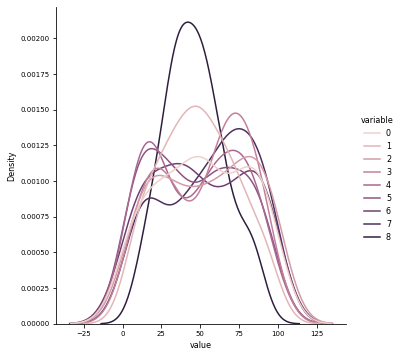

In [126]:
sns.displot(
    data=df2,
    x="value", hue="variable",
    kind="kde"
)

In [129]:
#posterior parameters
vi_parameters = dict(q="maf")

for i in range(1,pop_dim):
    
    if i == 1:
        theta, x = simulate_for_sbi(simulator, prior, num_sim)
        liklihood_estimator = inferer.append_simulations(theta, x).train()
        a_post = inferer.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
        posteriors[i-1] = a_post.set_default_x(true_x2).train(max_num_iters=10, quality_control=False )
        
        # Calculate p(i | X) ] = 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1))) where num_sim is the number of simulations
        #step 1 torch.sum(x, axis=1) # calculate sum(X_i_to_(pop_dim-1) for each simulation
        #step 2 x[:,i-1] / (torch.sum(x, axis=1)) # calculate X_i / sum(X_i_to_(pop_dim-1)) for each simulation
        #step 3 calculate 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1)))
        weights[i-1] = torch.mean(x[:,i-1] / (torch.sum(x, axis=1)))
        posterior = NeuralPosteriorEnsemble(posteriors, torch.tensor(weights))
        
    else:
        theta, x = simulate_for_sbi(simulator, posterior, num_sim)
        liklihood_estimator = inferer.append_simulations(theta, x).train()
        a_post = inferer.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
        posteriors[i-1] = a_post.set_default_x(true_x2).train(max_num_iters=10, quality_control=False )
        
        # Calculate p(i | X) ] = 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1))) where num_sim is the number of simulations
        #step 1 torch.sum(x, axis=1) # calculate sum(X_i_to_(pop_dim-1) for each simulation
        #step 2 x[:,i-1] / (torch.sum(x, axis=1)) # calculate X_i / sum(X_i_to_(pop_dim-1)) for each simulation
        #step 3 calculate 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1)))
        weights[i-1] = torch.mean(x[:,i-1] / (torch.sum(x, axis=1)))
        posterior = NeuralPosteriorEnsemble(posteriors, torch.tensor(weights))
        


Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 68 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 40 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 39 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/10 [00:00<?, ?it/s]

In [130]:
posterior.weights

tensor([0.1964, 0.1159, 0.0889, 0.0775, 0.0746, 0.0772, 0.0864, 0.1070, 0.1761])

In [131]:
posterior_indizes = torch.multinomial(torch.tensor(posterior.weights), 10000, replacement=True        )

/tmp/ipykernel_136934/1411508788.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_indizes = torch.multinomial(torch.tensor(posterior.weights), 10000, replacement=True        )


In [133]:
post_ind = torch.vstack(posterior_indizes.unique(return_counts=True)).T

In [137]:
post_samples = [None]*post_ind.shape[0]
for posterior_index, sample_size in post_ind:
    post_samples[posterior_index] = (posteriors[posterior_index].sample((1000,))).detach().cpu().numpy()

In [146]:
post_samples = np.squeeze(np.asarray(post_samples))


In [151]:
post_samples[0,:10]

array([61.947044, 62.803825, 24.934078, 15.65539 , 20.825752, 11.202608,
       51.120163, 21.395672, 17.032646,  8.481017], dtype=float32)

In [150]:
df3 = pd.DataFrame(post_samples.T, columns=list(range(0,9)))
df3.head()

,0,1,2,3,4,5,6,7,8
0,61.947044,72.374344,89.443756,14.942849,32.989647,20.727270,22.989912,21.776876,75.863487
1,62.803825,41.944031,45.286297,13.347749,51.696953,37.021667,64.299782,69.731323,84.567863
2,24.934078,12.239606,96.443230,59.130203,39.139687,96.809937,59.672245,83.419975,20.292452
3,15.655390,55.410629,46.009689,82.753418,40.810833,74.374634,7.867488,83.623344,45.486786
4,20.825752,43.560005,28.185097,9.227362,57.382633,66.798187,24.220041,15.538913,93.500595


In [152]:
df4= pd.melt(df3)
df4.head()

,variable,value
0,0,61.947044
1,0,62.803825
2,0,24.934078
3,0,15.655390
4,0,20.825752


In [155]:
df4.shape

(9000, 2)

In [159]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,7])

df4.columns=['Gamma','Frequency Bin']
df4.head()


,Gamma,Frequency Bin
0,0,61.947044
1,0,62.803825
2,0,24.934078
3,0,15.655390
4,0,20.825752


<Figure size 1080x504 with 0 Axes>

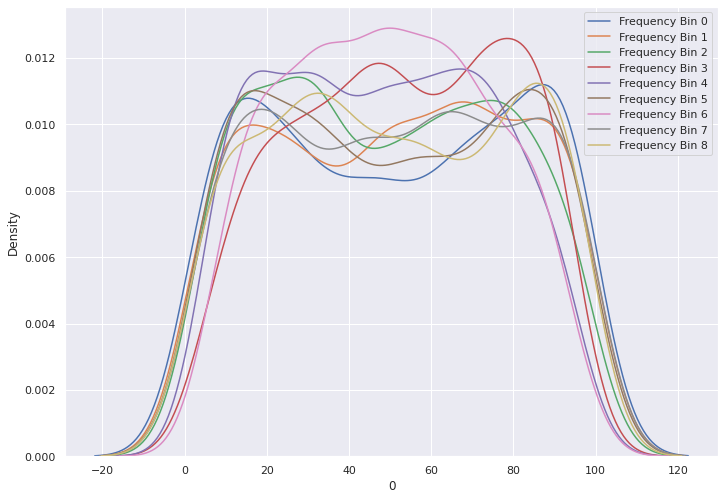

In [175]:
fig, ax = plt.subplots()
for i in range(0,9):
    sns.kdeplot(
    data=df3[i],
    ax=ax,
    label="Frequency Bin {}".format(i)
)
plt.legend()



In [176]:
df3.to_pickle('df3.pkl')
df4.to_pickle('df4.pkl')

In [181]:
# Multiround inference
#posterior parameters
num_sim=100
del inferer
inferer = SNLE(prior, show_progress_bars=True, device='cuda', density_estimator="maf")

for round in range(0,10):
    for i in range(1,pop_dim):
        
        if i == 1 and round == 0:
            theta, x = simulate_for_sbi(simulator, prior, num_sim)
            liklihood_estimator = inferer.append_simulations(theta, x).train()
            a_post = inferer.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
            posteriors[i-1] = a_post.set_default_x(true_x2).train(max_num_iters=40, quality_control=False )
            
            # Calculate p(i | X) ] = 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1))) where num_sim is the number of simulations
            #step 1 torch.sum(x, axis=1) # calculate sum(X_i_to_(pop_dim-1) for each simulation
            #step 2 x[:,i-1] / (torch.sum(x, axis=1)) # calculate X_i / sum(X_i_to_(pop_dim-1)) for each simulation
            #step 3 calculate 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1)))
            weights[i-1] = torch.mean(x[:,i-1] / (torch.sum(x, axis=1)))
            posterior = NeuralPosteriorEnsemble(posteriors, torch.tensor(weights))
            
        else:
            theta, x = simulate_for_sbi(simulator, posterior, num_sim)
            liklihood_estimator = inferer.append_simulations(theta, x).train()
            a_post = inferer.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
            posteriors[i-1] = a_post.set_default_x(true_x2).train(max_num_iters=40, quality_control=False )
            
            # Calculate p(i | X) ] = 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1))) where num_sim is the number of simulations
            #step 1 torch.sum(x, axis=1) # calculate sum(X_i_to_(pop_dim-1) for each simulation
            #step 2 x[:,i-1] / (torch.sum(x, axis=1)) # calculate X_i / sum(X_i_to_(pop_dim-1)) for each simulation
            #step 3 calculate 1/num_sim * (X_i / sum(X_i_to_(pop_dim-1)))
            weights[i-1] = torch.mean(x[:,i-1] / (torch.sum(x, axis=1)))
            posterior = NeuralPosteriorEnsemble(posteriors, torch.tensor(weights))
    theta_o = posterior.sample((1,))
    x_o, actual_fs = true_data(theta_o.repeat(num_iid_trials,1))
    true_x2 = x_o.cuda()  
        


/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:702: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  warnings.warn(


 Neural network successfully converged after 176 epochs.

/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/pyro/nn/auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(
/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

/mnt/sda/home/ludeep/Desktop/PopGen/FinBank/moments_sfs/momentssfs/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 34 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 56 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 42 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 46 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 31 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 40 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 33 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 106 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 34 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 31 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 32 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 43 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 40 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

  0%|          | 0/40 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

NameError: name 'posterior' is not defined

tensor([[59.4688]], device='cuda:0')